In [10]:
import seedir as sd
import pandas as pd
import pprint
import numpy as np

# Rapport SY23 - Prix d'hotels

## 1 - Introduction

Le projet consiste en l’étude d’un jeu de données de différents hôtels. En effet, plusieurs plaintes ont été reçues par la répression des fraudes d’un pays imaginaires. Ces plaintes ne concernent exclusivement des consommateurs basés en Europe et ayant réalisé des réservations dans des villes Européennes. L’organisme de répression des fraudes informe qu'elle souhaite concentrer les recherches sur 9 villes car, selon leurs experts métier, elles sont révélatrices du marché de l'hôtellerie en Europe.
Afin de pouvoir tester nos différents modèle, une API sera utilisée. Celle-ci permettra via la création d’avatars de pouvoir simuler des recherches d’hôtels d’après plusieurs paramètres (utilisation du téléphone, nationalité de l’avatar, destination et la durée entre le moment de réservation et le début de séjour).  Les requêtes réalisées au moyen de l’API permettront de ressortir une liste d’hôtel avec l’id de celui-ci, son prix et le nombre de chambre disponible.


## 2 - Architecture logicielle

### 2.1 - Architecture de fichiers

Lors de la réalisation de ce projet, nous avons dévellopé un package python nommé "datascience" qui contient l'ensemble des fonctions et classes dont nous avons besoin pour récuperer les données, pre traiter les données, créer des modèles de deep learning, les entrainer et les tester. Ce package est lui meme divisé en 5 sous-packages :

1. data_loading: Ce pakage sert à charger les données pour pouvoir les utilisées dans les modèles
2. data_recovery: Ce pakage sert à generer des requetes API pour pouvoir construire un jeu de données
3. model: Ce pakage fournit des classes abstraites pour pouvoir defenir des modèles de Machine Learning
4. utils: Ce package fournit des outils et données utilisables dans les autres packages
5. visualisation: Ce package fournit des fonctions pour pouvoir visualiser le dataset (histogrames)

L'architecture complete du package est disponible via le bloc de code ci-dessous.

In [6]:
sd.seedir('./datascience', exclude_folders=['__pycache__'], style='emoji')

📁 datascience/
├─📁 data_loading/
│ ├─📄 load_dataset.py
│ ├─📄 load_test_set.py
│ ├─📄 torch_dataloader.py
│ └─📄 __init__.py
├─📁 data_recovery/
│ ├─📄 recovery.py
│ ├─📄 update_dataset.py
│ └─📄 __init__.py
├─📁 model/
│ ├─📄 DeepLModel.py
│ ├─📄 MLModel.py
│ └─📄 __init__.py
├─📁 utils/
│ ├─📄 api_connector.py
│ ├─📄 data.py
│ ├─📄 exception.py
│ ├─📄 utils.py
│ └─📄 __init__.py
├─📁 visualisation/
│ ├─📄 city_distribution.py
│ └─📄 __init__.py
└─📄 __init__.py


### 2.2 - Architecture des classes

Pour mener à bien l'ensemble des taches necessaires afin de dévelloper des modèles, nous avons implementer un certains nombre de classes. Les diagrammes de classes ci-dessous montrent l'imbrications des classes entre elles. 

1. La classe Connector:

![Connector](./img/inria_classe_connector.png)

2. La classe CustomDataset:

![CustomDataset](./img/inria_classe_load_DataSet.png)

3. La classe Data:

![ConDatanector](./img/inria_classe_torch_dataset.png)

3. Les classes de modèle:

![Model](./img/inria_classe-MLmodel.drawio.png)


Ces classes permettent de réaliser l'ensemble des actions pour pouvoir définir et entrainer des modèles de Machine Learning. Cf les parties "Récuperations des données", "Préparation des données", "Chargement des données" et "Modèles" pour voir leurs utilisations.


## 3 - Recuperation des données

### 3.1 - Explication de l'API

Une API est mise en place pour faire des requêtes contenant les paramètres suivants:
- city : Nom de la ville où effectuer la recherche d’hôtels. Valeurs : ‘amsterdam’, ‘copenhagen’, ‘madrid’, ‘paris’, ‘rome’, ‘sofia’, ‘valletta’, ‘vienna’ et ‘vilnius’.
- date : Nombre de jours entre la date de la requête et le jour requêté (i.e. le nombre de jour entre le moment où vous regardez sur le site et le jour du check-in). Valeurs : Nombres positifs (entre 44 et 0).
- language : Langue de l’interface. Valeurs : ‘austrian’, ‘belgian’, ‘bulgarian’, ‘croatian’, ‘cypriot’, ‘czech’, ‘danish’, ‘dutch’, ‘estonian’, ‘finnish’, ‘french’, ‘german’, ‘greek’, ‘hungarian’, ‘irish’, ‘italian’, ‘latvian’, ‘lithuanian’, ‘luxembourgish’, ‘maltese’, ‘polish’, ‘portuguese’, ‘romanian’, ‘slovakian’, ‘slovene’, ‘spanish’ or ‘swedish’.
- mobile : Paramètre permettant de simuler une requête réalisée depuis un téléphone portable (au lieu d’un ordinateur). Valeurs : 1 (téléphone) ou 0 (ordinateur).
- avatar : Identifiant d’un utilisateur fictif (e.g. un faux compte client créé).

Nous avons implémenté un module api_connector pour assurer la communication avec l'API. Le module contient la classe connector. 
Un objet de type connector est instancié par un constructeur qui prend en paramètre une clé API unique obtenue auprès des organisateurs.

La classe contient aussi les methodes suivantes:
- create_avatar : Méthode statique qui fait un appel "POST" à l'API pour créer un nouvel utilisateur fictif (autrement dit avatar).
- get_avatar: Méthode statique qui fait un appel "GET" à l'API et retourne la liste d’avatars déjà disponibles avec leur ids et noms.
- query: Méthode statique qui prend en parametre les critères d'une recherche d'un hôtel et qui réalise un appel "GET" à l'API qui retourne: la liste des hôtels répondants aux critères demandés (identifiant de l'hôtel, prix, nombre de chambres restantes).

A Note que nous ne pouvons effectuer que 1000 requêtes par semaine.

### 3.2 - Réalisation et stockage des requêtes à l'API:

Pour représenter le mieux l'ensemble de toutes les requêtes par les requêtes effectuées, nous avons implémenté la stratégie suivante par les fonctions existantes dans le module utils:
- Création d'une liste de toutes les combinaisons de paramètres (ville, date, langue, mobile) pour stocker toutes les requêtes possibles (9*44*27*2 = 21384 requêtes possibles). Ces requêtes sont stockées dans un fichier possible_api_requests.csv. Un parametre "used" indique pour chaque requête si elle est déjà utilisée. La fonction qui génère ce fichier s'appelle generate_api_requests et n'a été utilisée qu'une seule fois.
- A partir d'un fichier répertoriant les hôtels de chaque ville (métadonnées fournies par les organisateurs), nous avons décidé que la répartition de nos requêtes entre villes reflète la répartition des hôtels entre villes. Par exemple, la ville ayant 35% des hôtels, aura 35% des requêtes. Pour cela, nous avons créé un histogramme permettant de visualiser le nombre d'hôtels par ville (la fonction get_distribution)et un pour visualiser le nombre de requêtes à faire par ville (generate_histo)

Le travail de réalisation des requêtes est confié au package data_recovery qui contient le module recovery.py. Celui-ci contient les fonctions suivantes :
- La fonction request() prend en parametre les valeurs 'city', 'language', 'date' et 'mobile' et appel la fonction query(), qui realise la requete. request() ajoute également les informations récupérées au dossier de l'ensemble de données dataset expliqué plus tard. Elle apporte également d'autres modifications aux fichiers de métadonnées dans le but de suivre l'exécution de la requête (par exemple, la mise à jour du paramètre "used").
- La fonction take_n_requests() qui génère aléatoirement les paramètres pour n requêtes en suivant les distributions des requêtes sur les villes. La fonction crée et affecte également un certain nombre d'avatars d'utilisateurs fictices à ces requêtes en appelant la fonction assigning_avatar(). La fonction retourne finalement l'ensemble de n requêtes à realiser vers l'API.
- La fonction making_n_requests() exécute les n requêtes générées en appelant l'API.
- update_dataset() ajoute les réponses aux n requêtes constituant notre jeu de données dans un fichier du répertoire dataset: dataset/ville/ville_langue.csv comme indiqué par la commande suivante :

In [2]:
sd.seedir('./dataset', depthlimit=2, itemlimit=3, style='emoji')

📁 dataset/
├─📁 amsterdam/
│ ├─📄 amsterdam_austrian.csv
│ ├─📄 amsterdam_belgian.csv
│ └─📄 amsterdam_bulgarian.csv
├─📁 copenhagen/
│ ├─📄 copenhagen_austrian.csv
│ ├─📄 copenhagen_belgian.csv
│ └─📄 copenhagen_bulgarian.csv
└─📁 madrid/
  ├─📄 madrid_austrian.csv
  ├─📄 madrid_belgian.csv
  └─📄 madrid_bulgarian.csv


In [20]:
file = "./dataset/amsterdam/amsterdam_austrian.csv"
df = pd.read_csv(file)
pd.options.display.max_columns = len(df.columns)
df

,hotel_id,price,stock,city,date,language,mobile,avatar_id,order_requests
0,375,109,46,amsterdam,31,austrian,0,78524,1
1,465,237,132,amsterdam,31,austrian,0,78524,1
2,52,157,57,amsterdam,31,austrian,0,78524,1
3,475,102,53,amsterdam,31,austrian,0,78524,1
4,945,148,76,amsterdam,31,austrian,0,78524,1
...,...,...,...,...,...,...,...,...,...
3107,193,143,96,amsterdam,41,austrian,1,202176,8
3108,706,104,89,amsterdam,41,austrian,1,202176,8
3109,430,167,165,amsterdam,41,austrian,1,202176,8
3110,835,103,93,amsterdam,41,austrian,1,202176,8


### 3.3 - Préparation des données

Pour preparer les donnees de l'entrainnement et de test de nos modeles, plusieurs implementation ont ete realises:
- La classe CustomDatset dans le module load__dataset.py du package data_loading: Une instance de type CustomDataset est instanciée en lui fournissant la matrice x de features indépendantes et le vecteur dépendant y. La classe contient plusieurs méthodes statiques pour gérer les types de ces matrices ainsi qu'une méthode split qui divise le jeu de données en 2: dataset et testset.
- La fonction apply() du module utils vise à transformer des features qualitatives en features quantitatives. Pour cela nous associons un identifiant numérique unique à chaque ville, à chaque langue, à chaque marque et à chaque groupe. La marque et le groupe de l'hôtel sont des features que nous avons ajoutées à notre jeu de données en consultant d'autres fichiers fournis par les organisateurs.

In [13]:
from datascience.utils import apply, language, city, brand, group
pprint.pprint(language)

{'austrian': 0,
 'belgian': 1,
 'bulgarian': 2,
 'croatian': 3,
 'cypriot': 4,
 'czech': 5,
 'danish': 6,
 'dutch': 7,
 'estonian': 8,
 'finnish': 9,
 'french': 10,
 'german': 11,
 'greek': 12,
 'hungarian': 13,
 'irish': 14,
 'italian': 15,
 'latvian': 16,
 'lithuanian': 17,
 'luxembourgish': 18,
 'maltese': 19,
 'polish': 20,
 'portuguese': 21,
 'romanian': 22,
 'slovakian': 23,
 'slovene': 24,
 'spanish': 25,
 'swedish': 26}


- La fonction one_hot_encoding() dans le module datascience.data_loading.torch_dataloader vise à encoder les colonnes catégorielles pour arriver a des resultat moins biaisee. L'idée est d'avoir un nombre binaire unique (o ou 1) pour chaque catégorie. Par conséquent, le nombre de chiffres est le nombre de catégories pour l'attribut catégoriel à encoder.
- Finalement, La fonction load_dataset() du module load_dataset.py du package data_loading prend comme paramètres le dossier de jeu de données récupéré depuis l'API et le fichier de features supplémentaires, elle les joint et renvoie un objet de type CustomDataset.

In [16]:
from datascience.data_loading import load_dataset
dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")
dataset.x

,city,date,language,mobile,...,parking,pool,children_policy,order_requests
0,2,26,16,1,...,0,0,0,4
1,3,17,14,1,...,0,0,0,1
2,1,1,16,0,...,0,0,0,1
3,0,2,16,1,...,0,0,0,3
4,0,8,4,1,...,0,0,0,1
...,...,...,...,...,...,...,...,...,...
696674,1,34,20,1,...,0,0,0,8
696675,2,42,6,0,...,0,0,0,5
696676,7,29,14,1,...,0,1,0,1
696677,4,26,20,0,...,0,0,0,3


In [23]:
dataset.y

,price
0,181
1,84
2,261
3,120
4,153
...,...
583872,133
583873,181
583874,67
583875,247


In [24]:
from datascience.data_loading import one_hot_encoding
one_hot_encoding(dataset.x) # dataset.x est la matrice des features indépendantes
# Après le one_hot_encoding : explosion du nombre de features (109 au lieu de 11)

,mobile,parking,pool,stock,order_requests,...,date_40,date_41,date_42,date_43,date_44
0,1,1,1,19,1,...,0,0,0,0,0
1,0,0,0,0,1,...,0,0,0,0,0
2,0,1,1,4,2,...,0,0,0,0,0
3,1,0,0,80,2,...,0,0,0,0,0
4,1,1,0,80,1,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
583872,0,1,0,0,1,...,0,0,0,0,0
583873,1,0,0,95,1,...,0,0,0,0,0
583874,0,1,0,0,2,...,0,0,0,0,0
583875,1,0,0,14,7,...,0,0,0,0,0


## 4 - Les modèles

### 4.1 - Modèles from scrach

#### 4.1.1 - Modèle sous forme de fonction

#### 4.1.1 - Modèle sous forme de classe

Pour donner suite à l'implementation from scractch de réseaux de neurones en utilisant des fonctions (cf 4.1.1) comme nous avons vu en TP et en cours. Nous avons décidé de développé un packages python permettant d'implementer des réseaux de neuronnes comme on le ferait si on utilisait un framework python comme Pytorch ou keras/tensorflow. 

Ce package se base sur l'utilisation de la programation orientée objet classique (classe, heritage, polymorphisme, etc..) ainsi que sur l'utilisation de patrons de conception (Streategy) pour permettre une plus grande modularité du code.

On a identifié différents elements necessaires pour pouvoir implementer un réseau de neurones (ci-apres):
1. Fonction d'activation
2. Fonction d'erreur
3. Méthode d'optimisation
4. Le type de couche
5. L'apprentissage (backpropagation)

On a donc défini des sous-packages pour chaque element. Voici l'architecture global du package (UTTnet).

In [17]:
sd.seedir('./UTTnet', exclude_folders=['__pycache__'], style='emoji')

📁 UTTnet/
├─📁 Activation/
│ ├─📄 Activation.py
│ ├─📄 Relu.py
│ ├─📄 Sigmoid.py
│ ├─📄 Tanh.py
│ └─📄 __init__.py
├─📁 Layer/
│ ├─📄 Conv1d.py
│ ├─📄 Dense.py
│ ├─📄 Layer.py
│ └─📄 __init__.py
├─📁 Metric/
│ ├─📄 Metric.py
│ ├─📄 Mse.py
│ ├─📄 Rmse.py
│ └─📄 __init__.py
├─📄 Network.py
├─📁 Optimizer/
│ ├─📄 Optimizer.py
│ ├─📄 SGD.py
│ └─📄 __init__.py
└─📄 __init__.py


Chaque sous-package fonctionne sur le même principe. Pour comprendre comment fonctionne le package UTTnet il faut comprendre comment fonctionne le patron de conception statregie dont voici le diagramme UML.

![Strategy](./img/Strategy_Pattern_in_UML.png)

Ce patron de conception permet de garantir la modularité du code en permettant l'implementation de nouveaux types d'objets tant qu'ils respectent certaines conditions (heritage une interface).

Dans le cas de ce package, nous avons adapté le patron de conception pour qu'il réponde à nos besoins. Nous allons parcourir les sous-packages dans l'odre pour expliquer leurs fonctionnement et leurs buts:

1. Metric: Ce sous-packages contient les classes pour implemnter à la fois les fonction d'erreurs et les metriques d'évaluation.

![Metric](./img/uttnet-metric.png)

2. Activation: Ce sous-package contient les classes necessaires pour implemnter différentes fonctions d'activations. Les classes sont utilisées à la fois pour la forward et la backward pass.

![Activation](./img/uttnet-Activation.png)

3. Layer: Ce sous-package contient l'ensemble des classes pour implementer différents types de couches. 

![Layer](./img/uttnet-Layer.png)

4. Optimizer: Ce sous-package contient les classes permettant de réaliser l'optimisation des poids des couches selon différentes méthodes.

![Optimizer](./img/uttnet-optim.png)


Maintenant que l'on a défini l'ensemble des sous packages, on peut representer la classe Network qui rassemble l'ensemble des classes vues précedement pour pouvoir implementer un réseau de neurones complet.

![Network](./img/uttnet-Network.png)

Il suffit d'instancier la classe Network puis de ajouter des couches avec la méthode add pour définir un réseau de neurones. Voici un exemple simple de réseau de neurones utilisant ce package en modelisant un xor. On commence par tester sur un probleme xor, car c'est un probleme tres simple et cela permet de vérifier que le package fonctionne bien.

In [21]:
from UTTnet import Network
from UTTnet.Activation import Tanh
from UTTnet.Metric import Mse
from UTTnet.Layer import Dense
from UTTnet.Optimizer import SGD

# We are going to test out module on a xor problem

x_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# Define the network
# Loss function is Mean Squared Error
# Optimizer is Stochastic Gradient Descent
model = Network(
    loss=Mse(),
    optimizer=SGD(learning_rate=0.1)
)

# Add two layers
# First layer 2 input and 3 output using tanh activation function and bias is set to true
model.add(Dense(2, 3, activation=Tanh()))
# Second layer 3 input and 1 output using tanh activation function and bias is set to true
model.add(Dense(3, 1, activation=Tanh()))

# Print the model
print(model)

# Train the model
loss = model.fit(x_train, y_train, epochs=1000)
# test the model on
out = model(x_train)
print(out)

Neural Network(
  layers = [
    Dense(input=2,output=3,bias=True,activation=Tanh)
    Dense(input=3,output=1,bias=True,activation=Tanh)
  ],
  Optimizer = SGB(lr=0.1),
  Loss function = MSE()
)



100%|██████████| 1000/1000 [00:00<00:00, 1471.20it/s]

[array([[0.00083551]]), array([[0.97808871]]), array([[0.97598867]]), array([[-0.00146649]])]


In [22]:
from UTTnet import Network
from UTTnet.Activation import Tanh,Relu
from UTTnet.Metric import Mse
from UTTnet.Layer import Dense
from UTTnet.Optimizer import SGD
from datascience.data_loading import one_hot_encoding
from datascience.data_loading import load_dataset
dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")
dataset.x = one_hot_encoding(dataset.x)
dataset.to_numpy()

In [26]:
model_2 = Network(
    loss=Mse(),
    optimizer=SGD()
)

model_2.add(Dense(109,109,activation=Tanh()))
model_2.add(Dense(109,1))


loss = model_2.fit(dataset.x[:1500], dataset.y[:1500], epochs=5)
# test the model on
out = model_2(dataset.x[2000])
print(f"x = {dataset.x[2000]}")
print(f"prediction = {out}")
print(f"true = {dataset.y[2000]}")

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]


OverflowError: (34, 'Result too large')

### 4.2 - Modèles pytorch

cpu
Epoch 0 - Training Loss : 4523.355122023395 - Validation loss : 504.47879560370194 - RMSE : 22.461
Epoch 1 - Training Loss : 370.5935397588511 - Validation loss : 313.3206763560312 - RMSE : 17.701
Epoch 2 - Training Loss : 291.7758449848203 - Validation loss : 275.62162286356875 - RMSE : 16.602
Epoch 3 - Training Loss : 266.25211808269205 - Validation loss : 257.3869790361639 - RMSE : 16.043
Epoch 4 - Training Loss : 253.56992570496024 - Validation loss : 247.33450874529387 - RMSE : 15.727
Epoch 5 - Training Loss : 245.04667609212953 - Validation loss : 241.30432902720938 - RMSE : 15.534
Epoch 6 - Training Loss : 239.24591231091313 - Validation loss : 235.51986926480345 - RMSE : 15.347
Epoch 7 - Training Loss : 234.68524000565625 - Validation loss : 232.20365664833471 - RMSE : 15.238
Epoch 8 - Training Loss : 230.97656960407653 - Validation loss : 229.80111673840304 - RMSE : 15.159
Epoch 9 - Training Loss : 228.36797812188217 - Validation loss : 228.58901164406225 - RMSE : 15.119


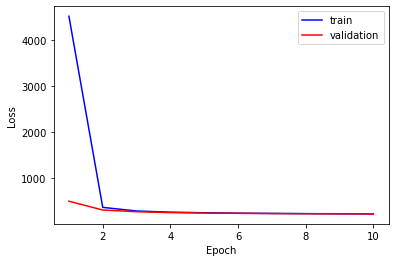

In [1]:
import torch
from datascience.model import DeepLearningModel
from torch.nn import Linear, Module, Dropout
from torch.nn.functional import tanh
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")


class NNModel(Module):
    def __init__(self):
        super().__init__()
        self.input = Linear(109, 109)
        self.output = Linear(109, 1)
        self.dropout = Dropout(0.2)

    def forward(self, x):
        x = tanh(self.input(x))
        return self.output(x)

    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()


epochs=10
model = NNModel()
nn = DeepLearningModel(model)
loss_values, val_loss_values = nn.train(epochs=epochs, learning_rate=0.001, batch_size=16, show=True)
x = list(range(1, epochs + 1))
plt.plot(x, loss_values, color='b', label='train')
plt.plot(x, val_loss_values, color='r', label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()